In [1]:
import os
import json
import sys
sys.path.append("../")

from tqdm import tqdm
import numpy as np
import utils
import matplotlib.pyplot as plt

In [2]:
data_dir = "../../data/google_patents/24054-jp-patents"
data_ratio = {"train": 0.8, "dev": 0.1, "test": 0.1}
random_state = np.random.RandomState(1)

save_data_path = os.path.join(data_dir, "data.ndjson")
save_label_path = os.path.join(data_dir, "doc_label_encoder.json")

In [3]:
doc_files = utils.get_file_name_in_dir(os.path.join(data_dir, "doc"), "json")
print("Number of document files:", len(doc_files))

Number of document files: 24054


**Data format:**

A .json file contains multiple patents on different lines.

Format of each patent:

```json
{
    "title": str,
    "pdf": str,
    "description": List[str],      # should be concatenated
    "claims": List[str],
    "classifications": List[str],   # each string uses "\n" to separate the cluster ID and its description 
}
```

In [4]:
sample_doc_file = doc_files[2]
with open(sample_doc_file, "r") as f:
    sample_doc = json.load(f)
    print("Document attributes:", sample_doc.keys())

Document attributes: dict_keys(['title', 'pdf', 'classifications', 'description', 'claims'])


In [5]:
sample_doc["classifications"]

['A61N1/0456\nSpecially adapted for transcutaneous electrical nerve stimulation [TENS]',
 'A61N1/0526\nHead electrodes',
 'A61N1/0551\nSpinal or peripheral nerve electrodes',
 'A61N1/36017\nExternal stimulators, e.g. with patch electrodes with leads or electrodes penetrating the skin',
 'A61N1/36025\nExternal stimulators, e.g. with patch electrodes for treating a mental or cerebral condition',
 'A61N1/36031\nControl systems using physiological parameters for adjustment',
 'A61N1/36034\nControl systems specified by the stimulation parameters',
 'A61N1/36053\nImplantable neurostimulators for stimulating central or peripheral nerve system adapted for vagal stimulation',
 'A61N1/36064\nEpilepsy',
 'A61N1/36085\nEating disorders or obesity',
 'A61N1/36089\nAddiction or withdrawal from substance abuse such as alcohol or drugs',
 'A61N1/36096\nMood disorders, e.g. depression, anxiety or panic disorder',
 'A61N1/361\nPhantom sensations, e.g. tinnitus',
 'A61N1/36114\nCardiac control, e.g. by v

In [6]:
def get_id(doc_file_name):
    x = os.path.basename(doc_file_name)
    return os.path.splitext(x)[0]
    
def get_content(doc):
    return "\n".join(doc["claims"])

def get_label(doc):
    res = set(x.split("\n")[0][:4] for x in doc["classifications"])
    return list(res)
    
def get_title(doc):
    return doc["title"]

def get_sample(doc, fname):
    return {"id": get_id(fname), "title": get_title(doc), "content": get_content(doc), "labels": get_label(doc)}

In [7]:
samples = []
for fname in doc_files:
    with open(fname, "r") as fin:
        doc = json.load(fin)
        if get_label(doc):
            samples.append(get_sample(doc, fname))
            
doc_ids = random_state.permutation([x["id"] for x in samples if x["labels"]])
print("Number of valid documents:", len(doc_ids))

Number of valid documents: 23884


In [8]:
freq = {}
for x in samples:
    for label in x["labels"]:
        freq[label] = freq.get(label, 0) + 1

labels = set(k for k, v in freq.items() if v >= 30)
label_ids = {x : i for i, x in enumerate(sorted(labels))}
utils.dump_json(label_ids, save_label_path)
print("Number of labels:", len(labels))

Number of labels: 227


In [9]:
new_samples = []
for sample in tqdm(samples):
    sample["labels"] = [e for e in sample["labels"] if e in labels]
    if len(sample["labels"]) != 0:
        new_samples.append(sample)

samples = new_samples

100%|██████████| 23884/23884 [00:00<00:00, 1012397.74it/s]


In [10]:
from skmultilearn.model_selection import iterative_train_test_split
X_raw = np.array([[x] for x in samples])
y_raw = np.matrix([utils.get_onehot(x["labels"], label_ids) for x in samples])
X, y = {}, {}
y_raw.shape

(23712, 227)

In [11]:
X["train"], y["train"], X["test"], y["test"] = iterative_train_test_split(X_raw, y_raw, test_size=0.1)

In [12]:
set(np.unique(np.where(y["train"] == 1)[1]).tolist()).difference(set(np.unique(np.where(y["test"] == 1)[1]).tolist()))

set()

In [13]:
X["train"], y["train"], X["dev"], y["dev"] = iterative_train_test_split(X["train"], y["train"], test_size=len(y["test"]) / len(y["train"]))

In [14]:
set(np.unique(np.where(y["train"] == 1)[1]).tolist()).difference(set(np.unique(np.where(y["dev"] == 1)[1]).tolist()))

set()

In [15]:
samples = []
for data_type in ("train", "dev", "test"):
    for sample in X[data_type]:
        sample = sample[0]
        sample["is_train"] = sample["is_dev"] = sample["is_test"] = False
        sample[f"is_{data_type}"] = True
        samples.append(sample)

In [16]:
with open(save_data_path, "w") as f:
    for sample in tqdm(samples):
        f.write(json.dumps(sample, ensure_ascii=False) + "\n")

100%|██████████| 23712/23712 [00:01<00:00, 20055.03it/s]


In [17]:
import pandas as pd
df = pd.DataFrame(samples)
df

,id,title,content,labels,is_train,is_dev,is_test
0,JP6856695B2,タービン・カートリッジを備えるオーバーハング・タービン及び発電機システム,シャフトと、\n ハウジングと、\n 複数の固定子板を含む少なくとも１つの固定子であって...,"[H02K, Y10T, F05D, B23P, Y02E, F02C, F16C]",True,False,False
1,JP6855484B2,下流側の電流ベースのモータ制御を有する外科用ステープラ,外科用ステープラであって、\n 駆動システムと、\n 前記駆動システムに機械的に結合され...,"[H02P, A61B]",True,False,False
2,JP6855454B2,外科用ステープルドライバアレイ,外科用ステープルカートリッジと共に動作可能に使用される外科用ステープルドライバアレイであって...,[A61B],True,False,False
3,JP6855432B2,遷移金属／ゼオライトｓｃｒ触媒,車両リーンバーン内燃機関のための排気システムであって、\n流れる排ガスを通過させる導管と、\...,"[Y02C, Y02T, B01J, C01B, B01D, Y02A]",True,False,False
4,JP6855430B2,遊技場における不正検知システム,複数の遊技テーブルを有する遊技場におけるテーブルゲームの管理システムであって、\n 前記遊...,"[G06Q, G07F, A63F]",True,False,False
...,...,...,...,...,...,...,...
23707,JP5585742B1,受信装置および通信方法,外部機器から、差動信号により、ＨＤＭＩケーブルを介して映像信号を受信する信号受信部と、\n ...,"[H04B, G09G, H04N]",False,False,True
23708,JP5576581B1,ユーザインターフェイス拡張システム,タッチインターフェイスデバイス（１０）のユーザインターフェイス拡張システムであって、\n ...,"[G06F, G08B]",False,False,True
23709,JP3214893U,携帯型薬剤ディスペンサー,複数の別々に含有された製剤を保持するためのチャンバーと；\n 分配機構の起動時に前記複数の...,"[G16H, A61J]",False,False,True
23710,JP3207426U,高電圧能力を有する高静電容量の多層,交互に配置される層内の複数の第１内部導電体および複数の第２内部導電体であって、前記第１内部導...,"[H01G, Y10T]",False,False,True


In [18]:
sum(df["is_train"]), sum(df["is_dev"]), sum(df["is_test"])

(18870, 2427, 2415)

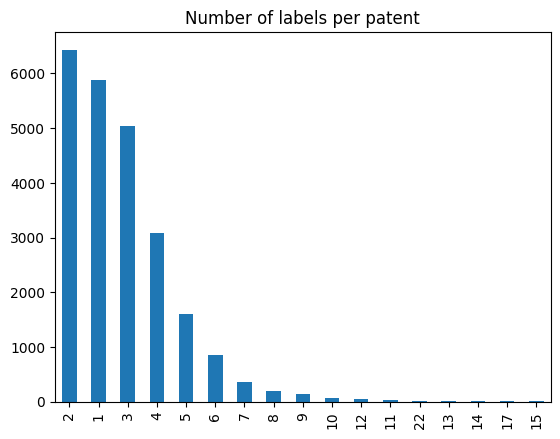

In [19]:
ax = df["labels"].apply(lambda x : len(x)).value_counts().plot(kind="bar");
ax.set_title("Number of labels per patent");
plt.show()

**Check**

In [21]:
df["content"].apply(lambda x : len(x.split())).mean()

44.30705971659919

In [22]:
len(label_ids)

227

In [23]:
df[df["content"].apply(lambda x : len(x)) == 0]

,id,title,content,labels,is_train,is_dev,is_test


In [24]:
res = set()
for x in df[df["is_train"]]["labels"].values:
    res.update(x)
len(res)

227

In [25]:
res = set()
for x in df[df["is_dev"]]["labels"].values:
    res.update(x)
len(res)

227

In [26]:
res = set()
for x in df[df["is_test"]]["labels"].values:
    res.update(x)
len(res)

227